In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os, sys
import random
import copy
import string
import torch
import torchvision
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
device='cpu'

In [3]:
print('using:', device)

using: cpu


In [4]:
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_size = len(testset) // 2
test_size = len(testset) - val_size
valset, testset = random_split(testset, [val_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 61439340.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


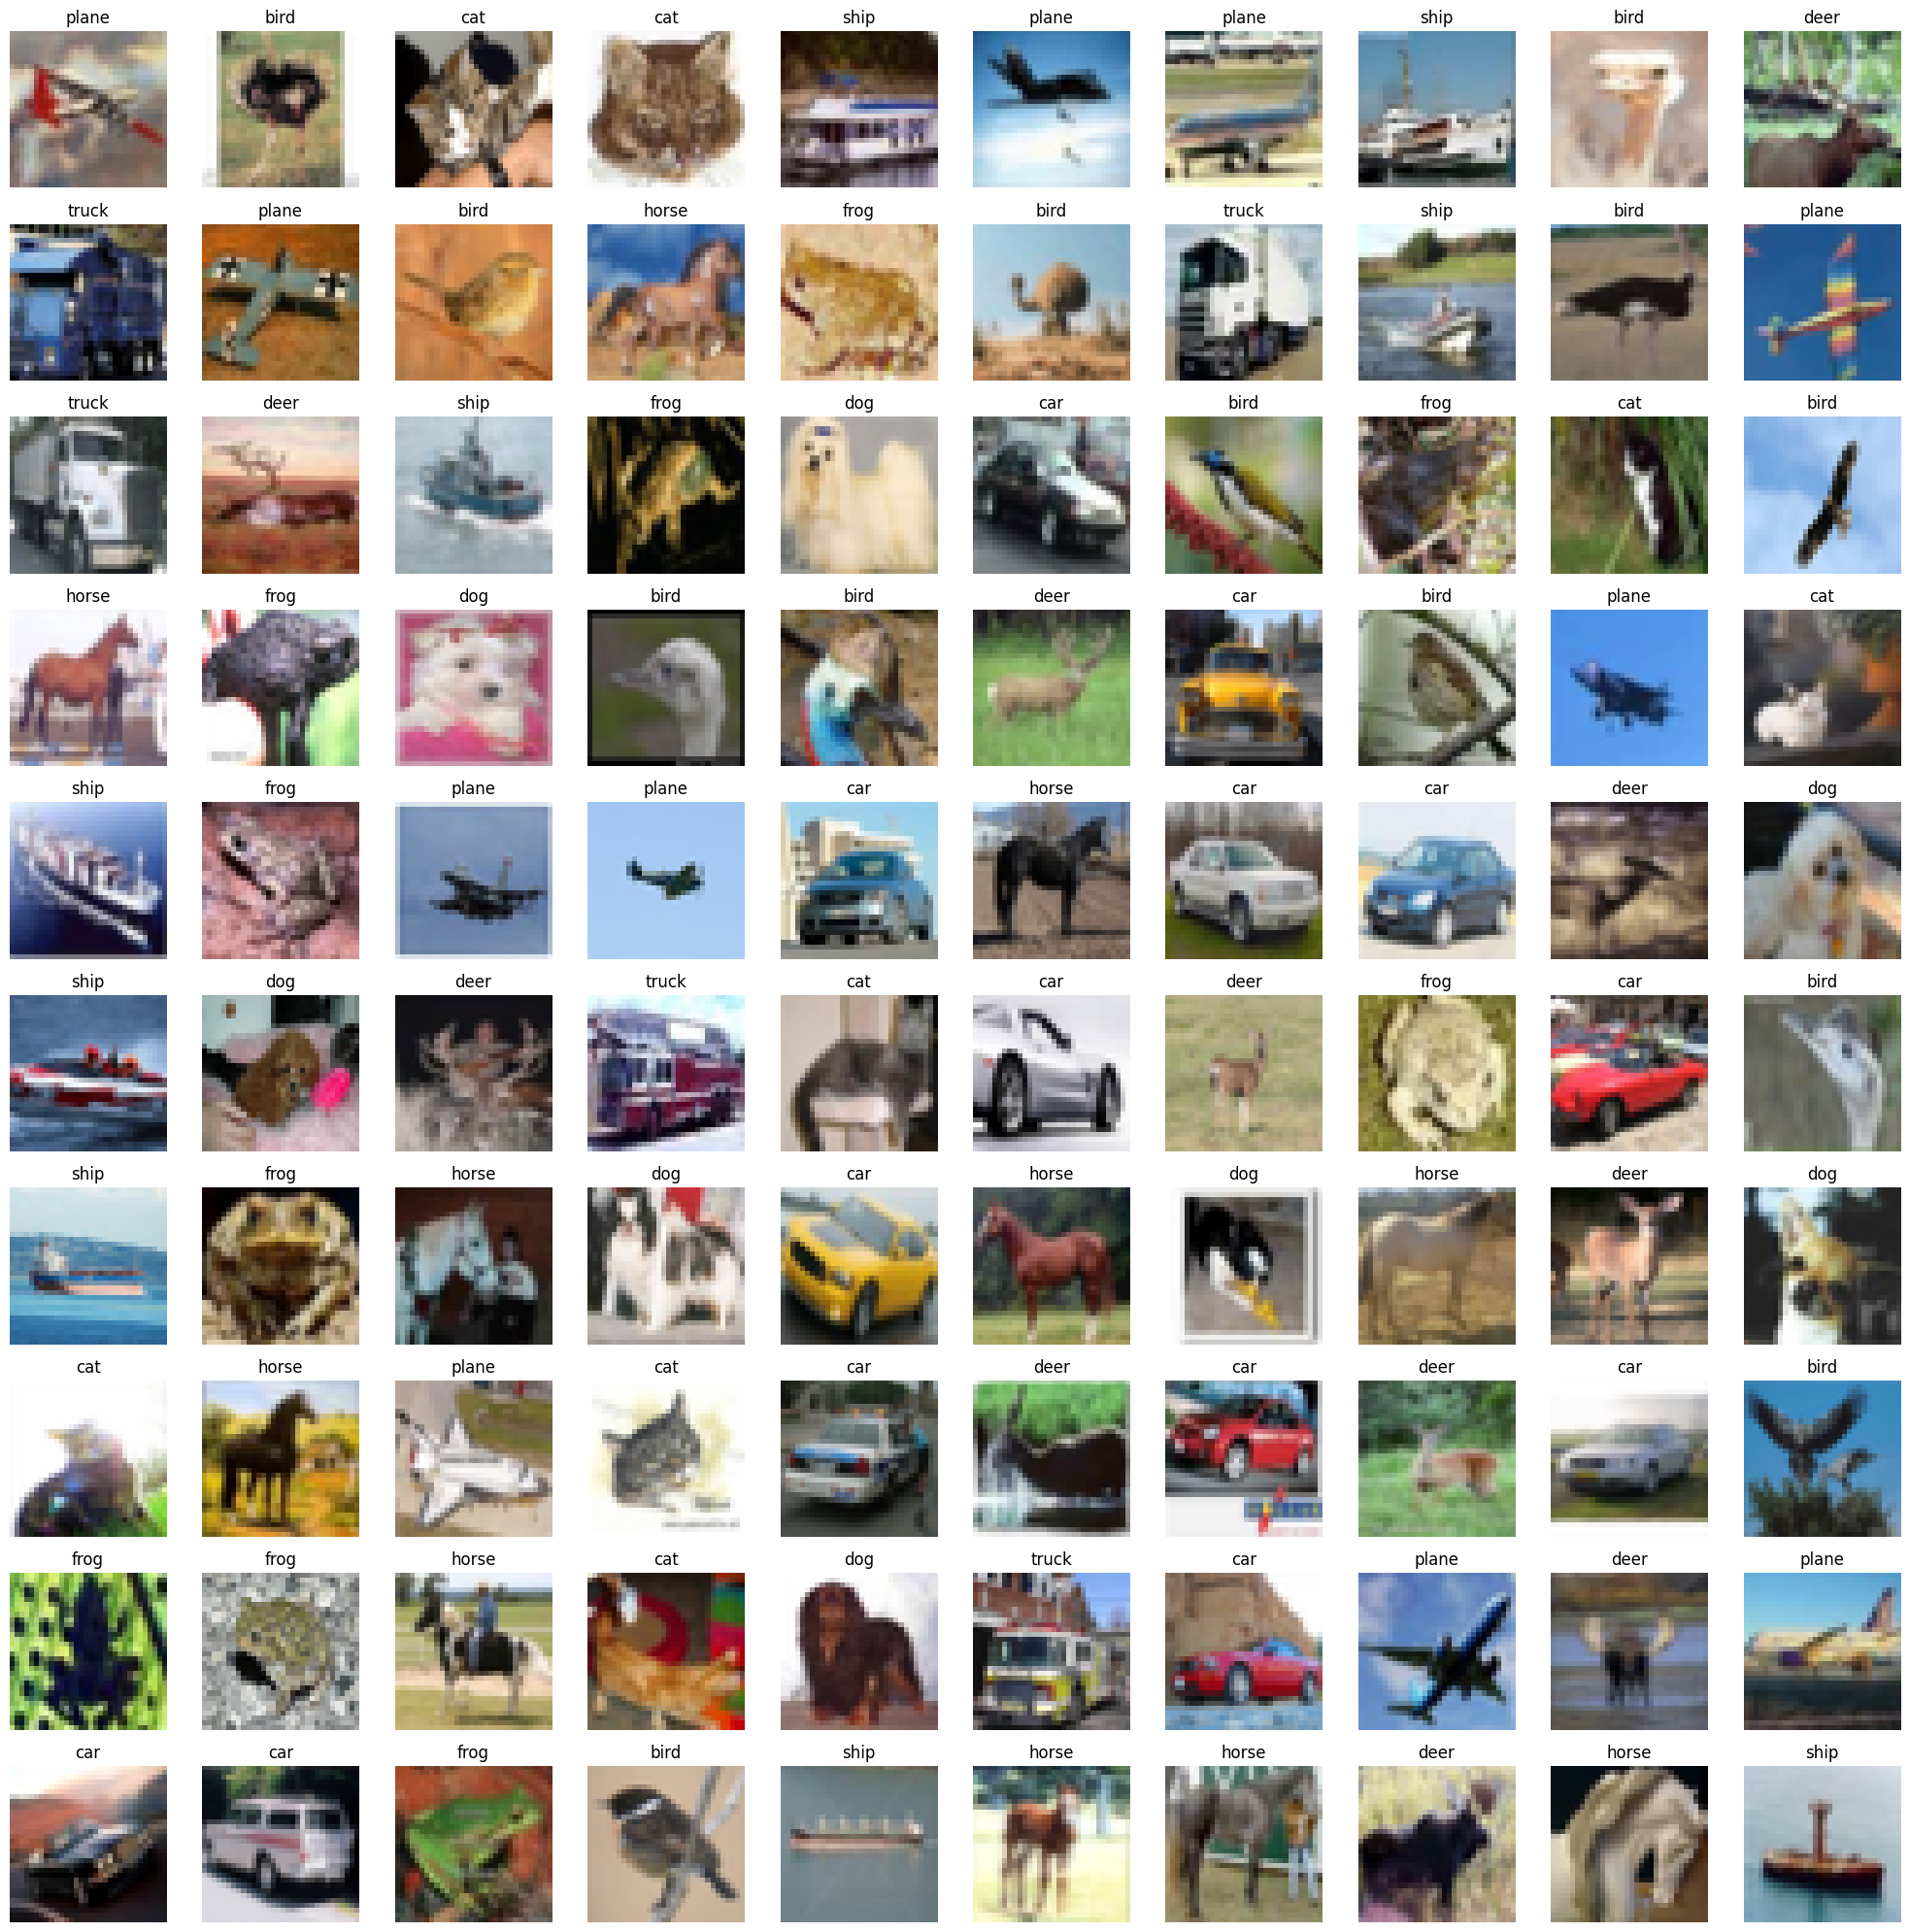

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        if idx < len(images):
            image = images[idx] / 2 + 0.5
            np_image = image.numpy()
            axes[i, j].imshow(np.transpose(np_image, (1, 2, 0)))
            axes[i, j].set_title(classes[labels[idx]])
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')
plt.tight_layout()
plt.show()

# Centralized Learning

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, max_epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in tqdm(range(max_epochs)):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{10}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 2.2017, Train Acc: 18.82%, Val Loss: 1.9460, Val Acc: 30.12%
Epoch [2/10], Train Loss: 1.7653, Train Acc: 35.75%, Val Loss: 1.5822, Val Acc: 42.42%
Epoch [3/10], Train Loss: 1.5575, Train Acc: 43.08%, Val Loss: 1.4663, Val Acc: 47.06%
Epoch [4/10], Train Loss: 1.4605, Train Acc: 46.99%, Val Loss: 1.4138, Val Acc: 49.32%
Epoch [5/10], Train Loss: 1.3846, Train Acc: 50.30%, Val Loss: 1.3364, Val Acc: 52.12%
Epoch [6/10], Train Loss: 1.3260, Train Acc: 52.51%, Val Loss: 1.3078, Val Acc: 52.80%
Epoch [7/10], Train Loss: 1.2752, Train Acc: 54.57%, Val Loss: 1.3399, Val Acc: 52.52%
Epoch [8/10], Train Loss: 1.2335, Train Acc: 56.35%, Val Loss: 1.1967, Val Acc: 57.32%
Epoch [9/10], Train Loss: 1.1931, Train Acc: 57.67%, Val Loss: 1.1842, Val Acc: 59.02%
Epoch [10/10], Train Loss: 1.1568, Train Acc: 59.06%, Val Loss: 1.1624, Val Acc: 59.22%


In [ ]:
model = CNN_Model(10)
model=model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.05)
train_losses, val_losses, train_accs, val_accs = train_model(model, trainloader, testloader, criterion, optimizer, 10, device)

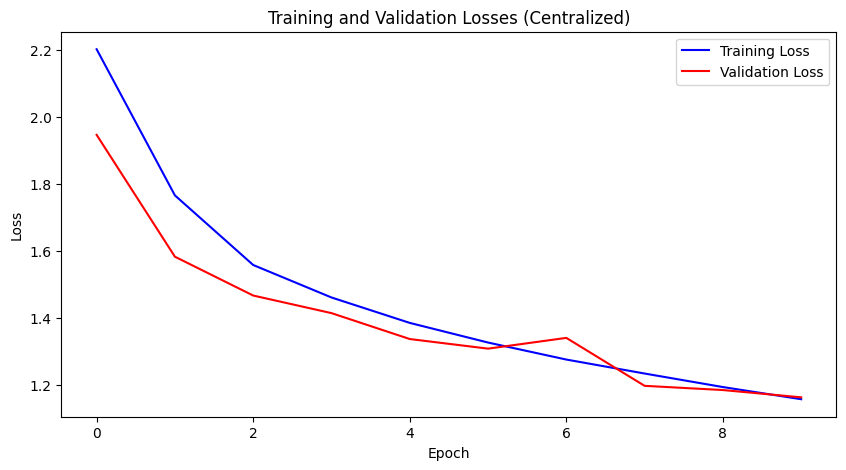

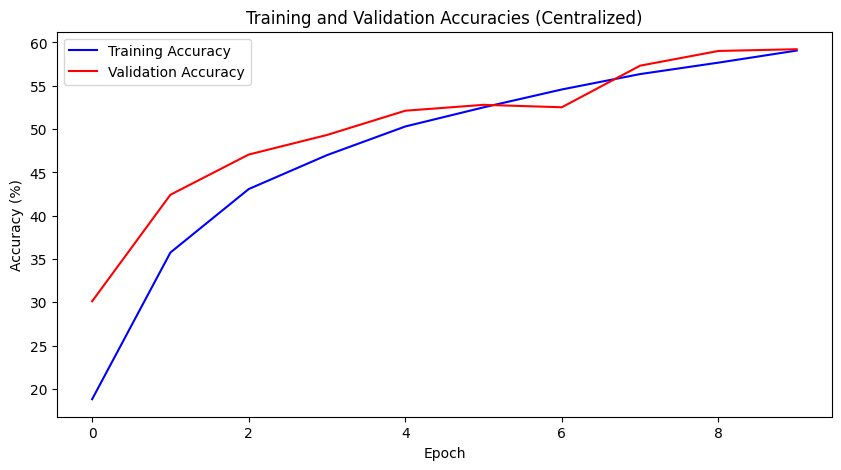

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Centralized with SGD)')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color='blue')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies (Centralized with SGD)')
plt.legend()
plt.show()


In [ ]:
model = CNN_Model(10)
model=model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.05)
train_losses, val_losses, train_accs, val_accs = train_model(model, trainloader, testloader, criterion, optimizer, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 2.1629, Train Acc: 19.35%, Val Loss: 1.8788, Val Acc: 31.74%
Epoch [2/10], Train Loss: 1.7510, Train Acc: 35.87%, Val Loss: 1.6287, Val Acc: 40.84%
Epoch [3/10], Train Loss: 1.5591, Train Acc: 43.43%, Val Loss: 1.4829, Val Acc: 47.66%
Epoch [4/10], Train Loss: 1.4504, Train Acc: 47.56%, Val Loss: 1.3902, Val Acc: 50.84%
Epoch [5/10], Train Loss: 1.3784, Train Acc: 50.58%, Val Loss: 1.3130, Val Acc: 53.58%
Epoch [6/10], Train Loss: 1.3122, Train Acc: 53.06%, Val Loss: 1.3073, Val Acc: 54.98%
Epoch [7/10], Train Loss: 1.2630, Train Acc: 55.13%, Val Loss: 1.2757, Val Acc: 54.84%
Epoch [8/10], Train Loss: 1.2132, Train Acc: 57.14%, Val Loss: 1.1833, Val Acc: 58.56%
Epoch [9/10], Train Loss: 1.1724, Train Acc: 58.58%, Val Loss: 1.1164, Val Acc: 60.48%
Epoch [10/10], Train Loss: 1.1359, Train Acc: 59.79%, Val Loss: 1.0969, Val Acc: 61.28%


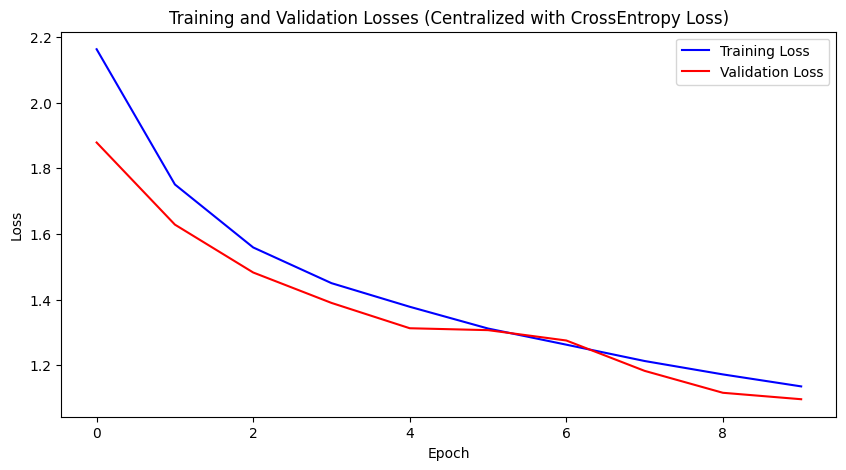

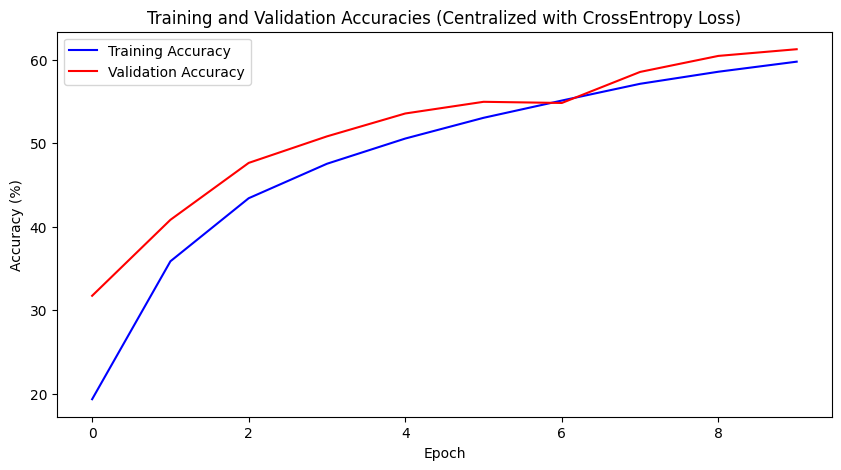

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Centralized with CrossEntropy Loss)')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color='blue')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies (Centralized with CrossEntropy Loss)')
plt.legend()
plt.show()


# Federated Learning

## FedAvg Algorithm

In [7]:
class FedAvgClientUpdate(object):
    def __init__(self, train_loader):
        self.train_loader = train_loader
        self.criterion = nn.CrossEntropyLoss()

    def update_model(self, model, max_epochs, learning_rate):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        train_losses = []
        train_accs = []

        for epoch in range(max_epochs):
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for data, labels in self.train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_train_loss / len(self.train_loader)
            train_acc = 100 * correct_train / total_train
            train_losses.append(train_loss)
            train_accs.append(train_acc)

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_acc = sum(train_accs) / len(train_accs)

        return model.state_dict(), avg_train_loss, avg_train_acc

    def federated_average(self, model_weights, model_prime_weights, coefficient):
        for key in model_weights.keys():
            model_weights[key] += coefficient * model_prime_weights[key]
        return model_weights


## FedAvg Training (IID Data)

In [8]:
def split_dataset(dataset, n, batch_size=50):
    N = len(dataset)
    n_i = N // n

    dataloaders = []

    for i in range(n):
        subset, dataset = torch.utils.data.random_split(dataset, [n_i, N - n_i])
        dataloaders.append(torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2))
        N -= n_i

    return dataloaders

n = 100
train_loaders2 = split_dataset(trainset, n)
test_loaders2 = split_dataset(testset, n)


In [9]:
def federated_training(model, train_loaders, test_loader, max_rounds, client_fraction, epochs_per_round, learning_rate, device):
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    criterion = nn.CrossEntropyLoss()
    weights_dict = copy.deepcopy(model.state_dict())

    for round_num in tqdm(range(max_rounds)):
        running_train_loss, running_val_loss, train_accuracy = 0.0, 0.0, 0.0
        train_count, val_count = 0, 0

        selected_clients = random.sample(list(np.arange(len(train_loaders))), k=int(client_fraction * len(train_loaders)))
        client_coefficients = [1 / len(selected_clients) for _ in range(len(train_loaders))]

        for key in weights_dict.keys():
            weights_dict[key] = torch.zeros_like(weights_dict[key])

        for client_index in selected_clients:
            client_update = FedAvgClientUpdate(train_loaders[client_index])
            client_weights, train_loss, train_acc = client_update.update_model(copy.deepcopy(model).to(device), epochs_per_round, learning_rate)
            weights_dict = client_update.federated_average(weights_dict, client_weights, client_coefficients[client_index])

            print(f"Train loss for client {client_index + 1} in round {round_num + 1} for {epochs_per_round} epochs: {train_loss}")
            running_train_loss += train_loss
            train_accuracy += train_acc
            train_count += 1

        model.load_state_dict(weights_dict)

        validation_accuracy = 0
        with torch.no_grad():
            for val_data, val_labels in test_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                batch_outputs = model(val_data)
                val_loss = criterion(batch_outputs, val_labels.long())
                running_val_loss += val_loss.item()
                validation_accuracy += torch.sum(torch.argmax(batch_outputs, dim=1) == val_labels.long()) / torch.numel(val_labels)
                val_count += 1

        print("-" * 10)
        print(f"Train loss in round {round_num + 1}: {running_train_loss / train_count}")
        print(f"Validation loss in round {round_num + 1}: {running_val_loss / val_count}")
        print(f"Train accuracy in round {round_num + 1}: {train_accuracy / train_count}%")
        print(f"Validation accuracy in round {round_num + 1}: {validation_accuracy / val_count * 100}%")
        print("-" * 10)

        train_losses.append(running_train_loss / train_count)
        train_accuracies.append(train_accuracy / train_count)
        validation_losses.append(running_val_loss / val_count)
        validation_accuracies.append(validation_accuracy / val_count * 100)

    return train_losses, validation_losses, train_accuracies, validation_accuracies


In [10]:
# Model
model = CNN_Model(10)
model.to(device)

max_rounds = 10
client_fraction = 0.1
epochs_per_round = 5
learning_rate = 0.01

train_losses, validation_losses, train_accuracies, validation_accuracies = federated_training(model, train_loaders2, testloader, max_rounds, client_fraction, epochs_per_round, learning_rate, device)


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss for client 22 in round 1 for 5 epochs: 2.306104907989502
Train loss for client 21 in round 1 for 5 epochs: 2.3051808357238768
Train loss for client 62 in round 1 for 5 epochs: 2.3029497385025026
Train loss for client 91 in round 1 for 5 epochs: 2.302445411682129
Train loss for client 76 in round 1 for 5 epochs: 2.3098990440368654
Train loss for client 69 in round 1 for 5 epochs: 2.299587368965149
Train loss for client 28 in round 1 for 5 epochs: 2.302658648490906
Train loss for client 27 in round 1 for 5 epochs: 2.3017294597625733
Train loss for client 36 in round 1 for 5 epochs: 2.294428291320801
Train loss for client 99 in round 1 for 5 epochs: 2.3011358070373538
----------
Train loss in round 1: 2.302611951351166
Validation loss in round 1: 2.3042539405822753
Train accuracy in round 1: 11.180000000000001%
Validation accuracy in round 1: 10.159997940063477%
----------
Train loss for client 25 in round 2 for 5 epochs: 2.3014726305007933
Train loss for client 45 in round 2 f

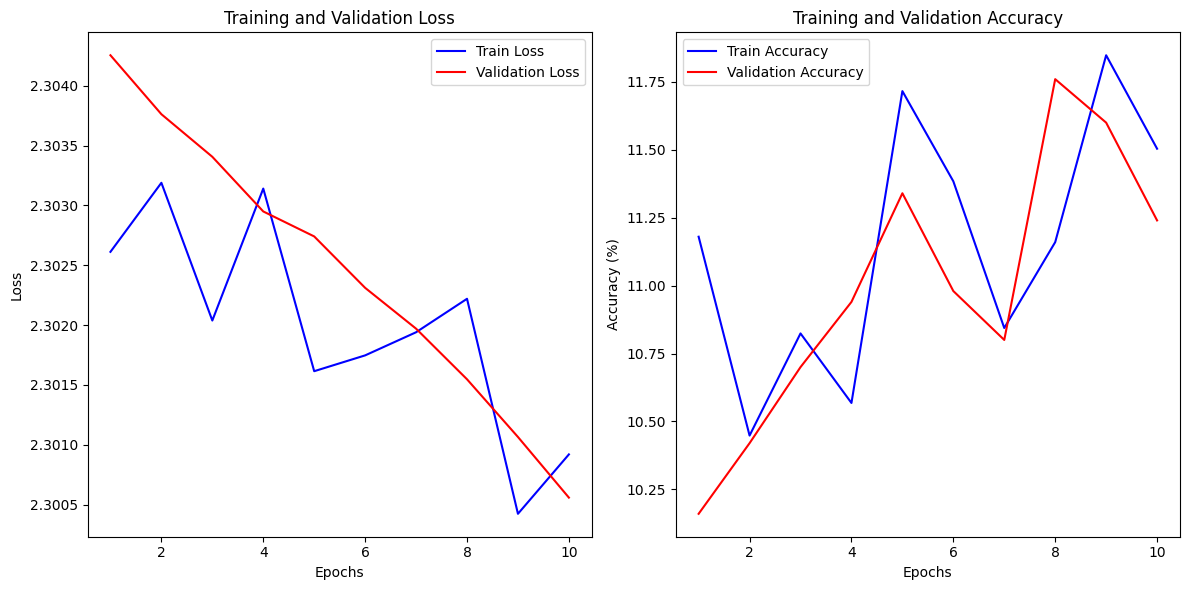

In [11]:
def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with your lists of metrics
plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)


## FedAvg Training (Non-IID Dataset)

In [27]:
class CustomCIFAR10(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        idx = self.indices[index]
        return self.dataset[idx]

def cifar_non_iid_sampling(dataset, num_users, batch_size):
    num_classes = 10
    samples_per_user_per_class = len(dataset) // num_users // 2  # each class items per client
    class_indices = {i: [] for i in range(num_classes)}

    # Collect indices for each class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Divide class indices into equal parts for each user
    for i in range(num_classes):
        class_indices[i] = [class_indices[i][x:x + samples_per_user_per_class] for x in range(0, len(class_indices[i]), samples_per_user_per_class)]

    # Assign samples to users while maintaining non-IID distribution
    users_data = {}
    idx = 0
    for user_id in range(num_users):
      if len(class_indices[idx]) > 0:
          users_data[user_id] = class_indices[idx][0]  # Add samples from current class
          del class_indices[idx][0]
      if len(class_indices) > idx + 1 and len(class_indices[idx + 1]) > 0:
          users_data[user_id] += class_indices[idx + 1][0]  # Add samples from next class
          del class_indices[idx + 1][0]
      # Update idx for the next iteration
      idx = (idx + 2) % num_classes


    # Create DataLoader for each user
    user_loaders = [torch.utils.data.DataLoader(CustomCIFAR10(dataset, users_data[i]), batch_size=batch_size, shuffle=True, num_workers=2) for i in range(num_users)]

    return user_loaders

# Example usage
num_users = 100
batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=2)
train_loaders = cifar_non_iid_sampling(trainset, num_users, batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=2)

Files already downloaded and verified


In [35]:
def federated_learning_round(model, train_loaders, test_loader, criterion, max_rounds, num_clients, learning_rate, device):
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    for round in tqdm(range(max_rounds)):
        running_train_loss = 0.0
        running_val_loss = 0.0
        train_accuracy = 0.0
        val_accuracy = 0.0
        train_count = 0
        val_count = 0

        clients = random.sample(list(np.arange(num_clients)), k=int(0.1 * num_clients))  # Select random clients
        client_weights = [1 / len(clients) for _ in range(num_clients)]  # Equal weights for each client

        # Initialize a dictionary to aggregate weights from clients
        aggregated_weights = {k: torch.zeros_like(v) for k, v in model.state_dict().items()}

        # Training on clients' data
        for client_id in clients:
            client_updater = FedAvgClientUpdate(train_loaders[client_id])
            client_weights_prime, client_loss, client_accuracy = client_updater.update_model(
                copy.deepcopy(model).to(device), E, learning_rate)

            # Aggregate client weights
            for key in aggregated_weights.keys():
                aggregated_weights[key] += client_weights_prime[key] * client_weights[client_id]

            # Print client's training loss
            print(f"Training loss for client {client_id + 1} in round {round + 1}: {client_loss}")

            # Accumulate training loss and accuracy
            running_train_loss += client_loss
            train_accuracy += client_accuracy
            train_count += 1

        # Update the model with aggregated weights
        model.load_state_dict(aggregated_weights)

        # Evaluate on validation data
        with torch.set_grad_enabled(False):
            for val_data, val_labels in test_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                outputs = model(val_data)
                val_loss = criterion(outputs, val_labels.long())
                running_val_loss += val_loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                val_accuracy += torch.sum(predicted == val_labels).item() / val_labels.size(0)
                val_count += 1

        # Print metrics for the current round
        print("-" * 10)
        print(f"Average training loss for round {round + 1}: {running_train_loss / train_count}")
        print(f"Average validation loss for round {round + 1}: {running_val_loss / val_count}")
        print(f"Average training accuracy for round {round + 1}: {train_accuracy / train_count}%")
        print(f"Average validation accuracy for round {round + 1}: {val_accuracy / val_count * 100}%")
        print("-" * 10)

        # Store metrics
        train_losses.append(running_train_loss / train_count)
        validation_losses.append(running_val_loss / val_count)
        train_accuracies.append(train_accuracy / train_count)
        validation_accuracies.append(val_accuracy / val_count * 100)

    return train_losses, validation_losses, train_accuracies, validation_accuracies

max_rounds = 10
C = 0.1
E = 5
learning_rate = 0.01
num_clients=100
model = CNN_Model(10)
model.to(device)
criterion = nn.CrossEntropyLoss()

train_losses, validation_losses, train_accuracies, validation_accuracies=federated_learning_round(model, train_loaders, testloader, criterion, max_rounds, num_clients, learning_rate, device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training loss for client 7 in round 1: 2.197752137184143
Training loss for client 93 in round 1: 2.1650938367843624
Training loss for client 98 in round 1: 2.164927101135254
Training loss for client 78 in round 1: 2.165272240638733
Training loss for client 87 in round 1: 2.197171955108643
Training loss for client 8 in round 1: 2.165173330307007
Training loss for client 54 in round 1: 2.1914213228225705
Training loss for client 60 in round 1: 2.1654671001434322
Training loss for client 56 in round 1: 2.152005043029785
Training loss for client 68 in round 1: 2.1650650024414064
----------
Average training loss for round 1: 2.1729349069595334
Average validation loss for round 1: 2.3068918001651766
Average training accuracy for round 1: 42.832%
Average validation accuracy for round 1: 9.999999999999993%
----------
Training loss for client 24 in round 2: 2.2182904148101805
Training loss for client 23 in round 2: 2.0589880394935607
Training loss for client 53 in round 2: 2.057938904762268
Tra

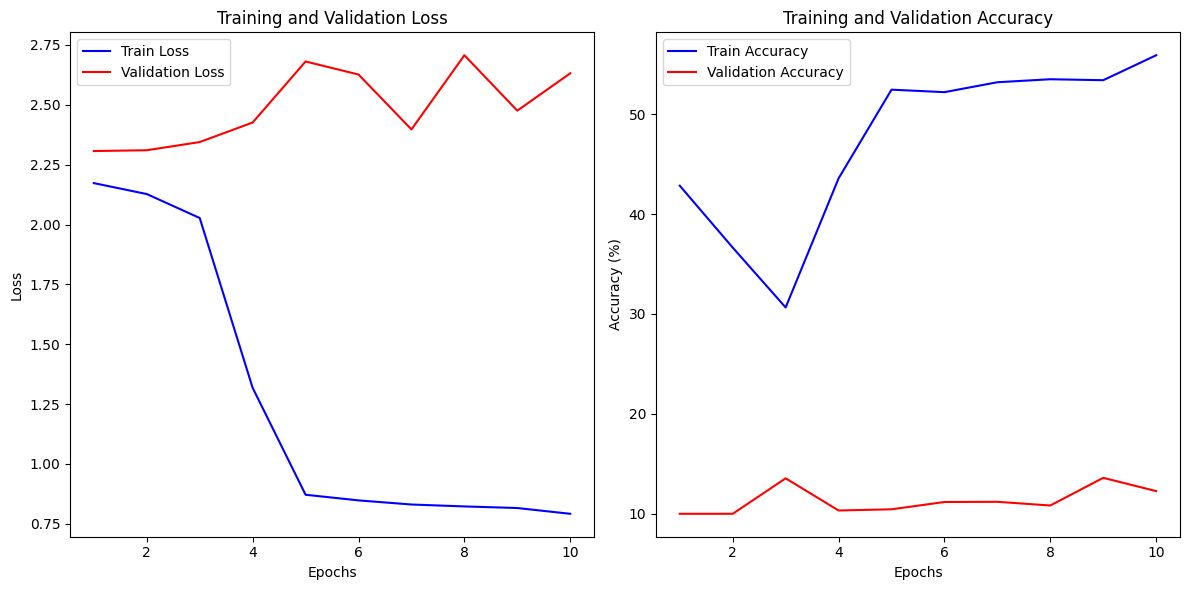

In [37]:
def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # validation_accuracies = [acc.item() for acc in validation_accuracies]

    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with your lists of metrics
plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)


## FedProx Algorithm

In [41]:
class FedProxClientUpdate(object):
    def __init__(self, train_loader):
        self.train_loader = train_loader
        self.criterion = nn.CrossEntropyLoss()

    def loss_function(self, model, w_t, batch_outputs, labels, mu):
        """
        Compute the loss function with the federated proximal term.

        Args:
            model: The neural network model.
            w_t: The model weights at time step t.
            batch_outputs: Predicted outputs by the model.
            labels: True labels.
            mu: Proximal term coefficient.

        Returns:
            The loss value.
        """
        model_weights = model.state_dict()
        loss1 = self.criterion(batch_outputs, labels)

        # Compute the proximal term
        loss2 = 0
        for layer_name, weights in model_weights.items():
            loss2 += torch.norm(weights.float() - w_t[layer_name].float(), p=2)

        return loss1 + (mu / 2) * loss2

    def update_model(self, model, max_epochs, lr, mu):
        """
        Update the model parameters.

        Args:
            model: The neural network model.
            max_epochs: Maximum number of epochs for training.
            lr: Learning rate.
            mu: Proximal term coefficient.

        Returns:
            Updated model weights, average training loss, and average training accuracy.
        """
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        w_t = copy.deepcopy(model.state_dict())

        train_losses = []
        train_accuracies = []

        # Loop over epochs
        for epoch in range(max_epochs):
            running_train_loss, train_accuracy = 0.0, 0.0
            train_count = 0

            # Training
            for data, labels in self.train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data)

                # Calculate loss
                loss = self.loss_function(model, w_t, outputs, labels, mu)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Update statistics
                running_train_loss += loss.item()
                train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels.long()) / torch.numel(labels)
                train_count += 1

            # Compute average loss and accuracy for the epoch
            train_losses.append(running_train_loss / train_count)
            train_accuracies.append(train_accuracy / train_count)

        # Return updated model weights and metrics
        return model.state_dict(), sum(train_losses) / len(train_losses), sum(train_accuracies) / len(train_accuracies)

    def federated_average(self, w_dict, w_prime_dict, coeff):
        """
        Perform federated averaging of model weights.

        Args:
            w_dict: Dictionary containing the model weights.
            w_prime_dict: Dictionary containing the updates to model weights from clients.
            coeff: Coefficient for combining the updates.

        Returns:
            Updated model weights after federated averaging.
        """
        for key in w_dict.keys():
            w_dict[key] = w_dict[key] + coeff * w_prime_dict[key]
        return w_dict


In [ ]:
class FedProx_ClientUpdate(object):

    def __init__(self, train_loader):

        self.train_loader =  train_loader

        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def loss_function(self, net, w_t,batch_train_outputs, train_labels, mu):
        w_dict = net.state_dict()
        loss1 = self.criterion(batch_train_outputs, train_labels)

        loss2 = 0
        for l in w_dict.keys():
            loss2 += torch.norm(w_dict[l].float() - w_t[l].float(), p = 2)

        return loss1 + (mu /2) * loss2

    def update(self, net, max_epochs, lr, mu):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)
        w_t = copy.deepcopy(net.state_dict())

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):

            running_trainloss,  train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.loss_function(net, w_t, batch_train_outputs, train_labels, mu)
                loss.backward()
                optimizer.step()

                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1

            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs)/len(train_accs)

    def federated_average(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## FedProx Training

In [42]:
def train_with_fedprox(model, train_loaders, test_loader, max_rounds, mu, learning_rate):
    """
    Train a federated learning model with the Federated Proximal (FedProx) algorithm.

    Args:
        model: The neural network model.
        train_loaders: List of DataLoader objects for training data of each client.
        test_loader: DataLoader object for test data.
        max_rounds: Maximum number of communication rounds.
        mu: Proximal term coefficient.
        learning_rate: Learning rate for optimization.

    Returns:
        Lists of training and validation losses, and training and validation accuracies.
    """
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_losses = []
    validation_losses = []
    train_accuracies = []
    val_accuracies = []

    w_dict = copy.deepcopy(model.state_dict())

    for round in tqdm(range(max_rounds)):
        running_train_loss = 0.0
        running_val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        train_cnt = 0
        val_cnt = 0

        # Sample clients for this round
        clients = random.sample(range(len(train_loaders)), k=int(0.1 * len(train_loaders)))
        coeffs = [1 / len(clients) for _ in range(len(train_loaders))]

        # Initialize w_prime_dict with zeros
        w_prime_dict = {k: torch.zeros_like(v) for k, v in w_dict.items()}

        # Training
        for i in clients:
            cl_upd = FedProxClientUpdate(train_loaders[i])
            w_prime, train_loss, acc = cl_upd.update_model(copy.deepcopy(model).to(device), E, learning_rate, mu)
            w_prime_dict = cl_upd.federated_average(w_prime_dict, w_prime, coeffs[i])
            print(f"Train loss for client {i+1} in round {round + 1} for {E} epochs: {train_loss}")
            running_train_loss += train_loss
            train_acc += acc
            train_cnt += 1

        # Update the model with the federated average of client updates
        model.load_state_dict({k: w_dict[k] + w_prime_dict[k] for k in w_dict.keys()})

        # Validation
        with torch.no_grad():
            for val_data, val_labels in test_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                batch_outputs = model(val_data)
                val_loss = criterion(batch_outputs, val_labels.long())
                running_val_loss += val_loss.item()
                val_acc += torch.sum(torch.argmax(batch_outputs, dim=1) == val_labels.long()) / torch.numel(val_labels)
                val_cnt += 1

        # Compute average metrics
        train_losses.append(running_train_loss / train_cnt)
        validation_losses.append(running_val_loss / val_cnt)
        train_accuracies.append(train_acc / train_cnt * 100)
        val_accuracies.append(val_acc / val_cnt * 100)

        # Print round-wise metrics
        print("-" * 10)
        print(f"Train loss in round {round + 1}: {running_train_loss / train_cnt}")
        print(f"Validation loss in round {round + 1}: {running_val_loss / val_cnt}")
        print(f"Train accuracy in round {round + 1}: {train_acc / train_cnt * 100}%")
        print(f"Validation accuracy in round {round + 1}: {val_acc / val_cnt * 100}%")
        print("-" * 10)

    return train_losses, validation_losses, train_accuracies, val_accuracies

max_rounds = 10
C = 0.1
E = 5
mu = 3
learning_rate = 0.01
w_dict = copy.deepcopy(model.state_dict())
train_losses, validation_losses, train_accuracies, validation_accuracies= train_with_fedprox(model, train_loaders, testloader, max_rounds, mu, learning_rate)


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss for client 76 in round 1 for 5 epochs: 7.943346178531646
Train loss for client 87 in round 1 for 5 epochs: 6.208064708709717
Train loss for client 81 in round 1 for 5 epochs: 7.4153394246101385
Train loss for client 66 in round 1 for 5 epochs: 7.667857887744903
Train loss for client 51 in round 1 for 5 epochs: 7.590430078506469
Train loss for client 67 in round 1 for 5 epochs: 6.429044008255007
Train loss for client 68 in round 1 for 5 epochs: 3.985246179103851
Train loss for client 62 in round 1 for 5 epochs: 6.4623810172080995
Train loss for client 27 in round 1 for 5 epochs: 6.581572809219361
Train loss for client 47 in round 1 for 5 epochs: 6.169680080413817
----------
Train loss in round 1: 6.6452962372303
Validation loss in round 1: 68.50131801605225
Train accuracy in round 1: 57.36399841308594%
Validation accuracy in round 1: 15.240010261535645%
----------
Train loss for client 90 in round 2 for 5 epochs: 72.67602151870729
Train loss for client 8 in round 2 for 5 epoc

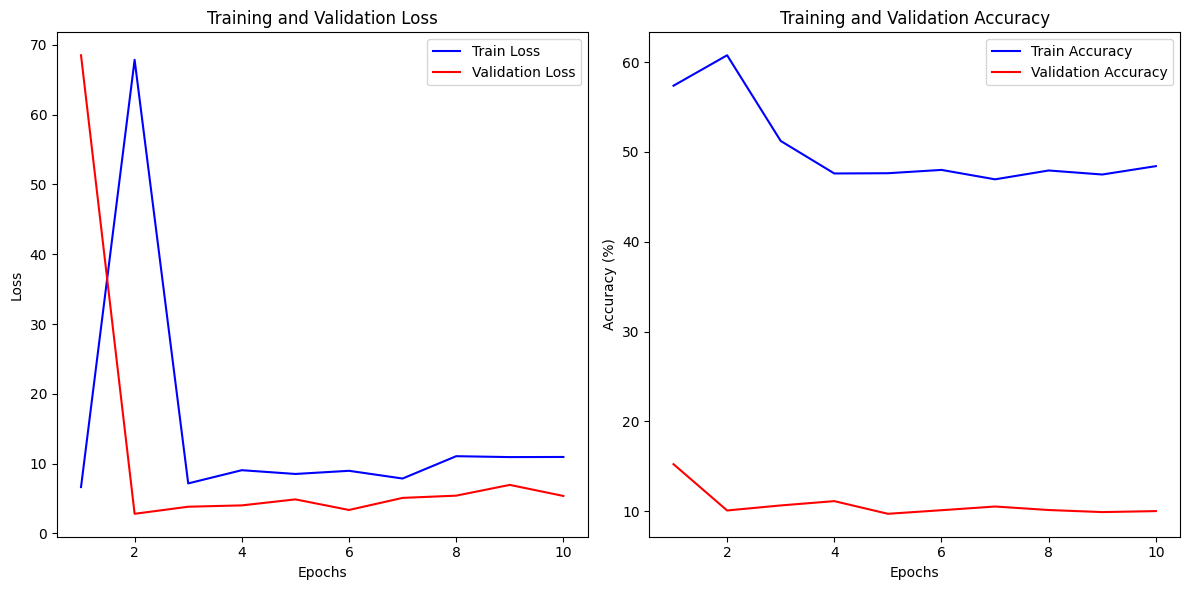

In [43]:
def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # validation_accuracies = [acc.item() for acc in validation_accuracies]

    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with your lists of metrics
plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)



## FedAdaGrad Algorithm

In [44]:
class FedAdagradClientUpdate(object):

    def __init__(self, train_loader):

        self.train_loader = train_loader

        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update_model(self, net, max_epochs, lr, client_lr):
        # Initialize the Adagrad optimizer
        optimizer = optim.Adagrad(net.parameters(), lr=client_lr)

        train_losses = []
        train_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # Forward pass
                batch_train_outputs = net(train_data)

                # Calculate loss
                loss = self.criterion(batch_train_outputs, train_labels)

                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()

                # Update running loss and accuracy
                running_trainloss += loss.item()
                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim=1) == train_labels.long()) / torch.numel(train_labels)
                train_cnt += 1

            # Average losses and accuracies over the epoch
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt)

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs)

    def federated_average(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict


In [50]:
class FedAdagradClientUpdate(object):
    def __init__(self, train_loader):
        self.train_loader = train_loader
        self.criterion = nn.CrossEntropyLoss()

    def calculate_loss(self, net, w_t, batch_train_outputs, train_labels, mu):
        w_dict = net.state_dict()
        loss1 = self.criterion(batch_train_outputs, train_labels)
        loss2 = sum(torch.norm(w_dict[l].float() - w_t[l].float(), p=2) for l in w_dict.keys())
        return loss1 + (mu / 2) * loss2

    def update_model(self, net, max_epochs, lr, client_lr):
        optimizer = optim.Adagrad(net.parameters(), lr=client_lr)
        w_t = copy.deepcopy(net.state_dict())
        train_losses = []
        train_accs = []

        for epoch in range(max_epochs):
            running_train_loss, train_acc = 0.0, 0.0
            train_cnt = 0

            for train_data, train_labels in self.train_loader:
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                optimizer.zero_grad()
                batch_train_outputs = net(train_data)
                loss = self.calculate_loss(net, w_t, batch_train_outputs, train_labels, mu)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim=1) == train_labels.long()) / torch.numel(train_labels)
                train_cnt += 1

            train_losses.append(running_train_loss / train_cnt)
            train_accs.append(train_acc / train_cnt)

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs)

    def federated_average(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict


## FedAdaGrad Training

In [51]:
def train_with_fedadagrad(model, train_loaders, test_loader, max_rounds, mu, learning_rate, client_lr):
    """
    Train a federated learning model with the Federated Adagrad (FedAdagrad) algorithm.

    Args:
        model: The neural network model.
        train_loaders: List of DataLoader objects for training data of each client.
        test_loader: DataLoader object for test data.
        max_rounds: Maximum number of communication rounds.
        mu: Proximal term coefficient.
        learning_rate: Learning rate for global model optimization.
        client_lr: Learning rate for client model optimization.

    Returns:
        Lists of training and validation losses, and training and validation accuracies.
    """
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_losses = []
    validation_losses = []
    train_accuracies = []
    val_accuracies = []

    w_dict = copy.deepcopy(model.state_dict())
    n = len(train_loaders)

    for round in tqdm(range(max_rounds)):
        running_train_loss = 0.0
        running_val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        train_cnt = 0
        val_cnt = 0

        clients = random.sample(range(n), k=int(0.1 * n))
        coeffs = [1 / len(clients) for _ in range(n)]

        for k in w_dict.keys():
            w_dict[k] = torch.zeros_like(w_dict[k])

        for i in clients:
            cl_upd = FedAdagradClientUpdate(train_loaders[i])
            w_prime_dict, train_loss, acc = cl_upd.update_model(copy.deepcopy(model).to(device), E, learning_rate,client_lr)
            w_dict = cl_upd.federated_average(w_dict, w_prime_dict, coeffs[i])
            print(f"Train loss for client {i + 1} in round {round + 1} for {E} epochs: {train_loss}")
            running_train_loss += train_loss
            train_acc += acc
            train_cnt += 1

        model.load_state_dict(w_dict)

        with torch.set_grad_enabled(False):
            for val_data, val_labels in test_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                batch_outputs = model(val_data)
                val_loss = criterion(batch_outputs, val_labels.long())
                running_val_loss += val_loss.item()
                val_acc += torch.sum(torch.argmax(batch_outputs, dim=1) == val_labels.long()) / torch.numel(val_labels)
                val_cnt += 1

        train_losses.append(running_train_loss / train_cnt)
        validation_losses.append(running_val_loss / val_cnt)
        train_accuracies.append(train_acc / train_cnt * 100)
        val_accuracies.append(val_acc / val_cnt * 100)

        print("-" * 10)
        print(f"Train loss in round {round + 1}: {running_train_loss / train_cnt}")
        print(f"Validation loss in round {round + 1}: {running_val_loss / val_cnt}")
        print(f"Train accuracy in round {round + 1}: {train_acc / train_cnt * 100}%")
        print(f"Validation accuracy in round {round + 1}: {val_acc / val_cnt * 100}%")
        print("-" * 10)

    return train_losses, validation_losses, train_accuracies, val_accuracies

model = CNN_Model(10)
model.to(device)

max_rounds = 10
C = 0.1
E = 5
mu = 3
learning_rate = 0.01
client_lr = 0.001
train_losses, validation_losses, train_accuracies, validation_accuracies=train_with_fedadagrad(model, train_loaders, testloader, max_rounds, mu, learning_rate, client_lr)

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss for client 19 in round 1 for 5 epochs: 5.121172556877136
Train loss for client 43 in round 1 for 5 epochs: 5.1813011693954465
Train loss for client 60 in round 1 for 5 epochs: 5.1651479578018185
Train loss for client 93 in round 1 for 5 epochs: 5.161578450202943
Train loss for client 77 in round 1 for 5 epochs: 5.208329038619995
Train loss for client 62 in round 1 for 5 epochs: 5.138737053871155
Train loss for client 45 in round 1 for 5 epochs: 5.162818183898926
Train loss for client 99 in round 1 for 5 epochs: 5.124008855819702
Train loss for client 81 in round 1 for 5 epochs: 5.128021850585937
Train loss for client 64 in round 1 for 5 epochs: 5.141195759773254
----------
Train loss in round 1: 5.153231087684632
Validation loss in round 1: 2.3381910872459413
Train accuracy in round 1: 54.540000915527344%
Validation accuracy in round 1: 10.010005950927734%
----------
Train loss for client 81 in round 2 for 5 epochs: 3.0468173313140867
Train loss for client 87 in round 2 for 

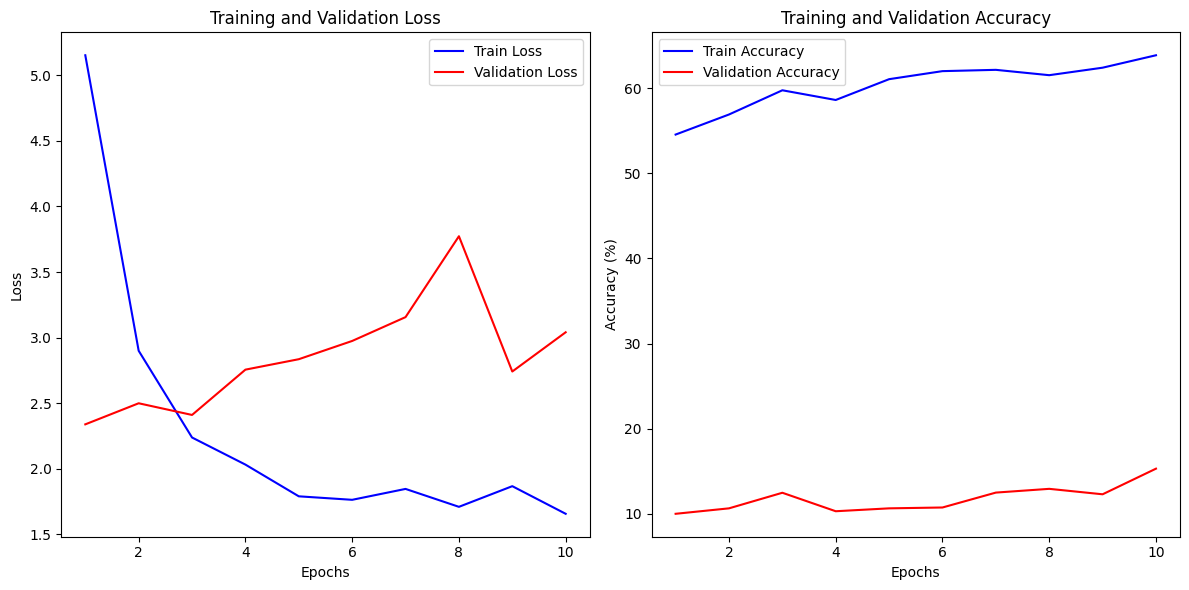

In [53]:
def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # validation_accuracies = [acc.item() for acc in validation_accuracies]

    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with your lists of metrics
plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)
